In [1]:
import torch.nn as nn
import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from torchvision import datasets
from torch.optim import lr_scheduler
import torch.optim as optim

import numpy as np
import os, random
import time
from PIL import Image
import copy
import pandas as pd
import matplotlib.pyplot as plt

# Loading data

In [2]:
#Data transformations for data augmentation
jitter_param = 0.05
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(512),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(
            brightness=jitter_param,
            contrast=jitter_param,
            saturation=jitter_param),
        transforms.RandomRotation(degrees=(-10,10), 
                                  resample=False, 
                                  expand=False, 
                                  center=None, 
                                  fill=None),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

val_transform = transforms.Compose([
        transforms.Resize(544),
        transforms.CenterCrop(512),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

#We define the dataset class
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, imgs, labels, transform=None):
        self.imgs = imgs
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, ix):
        img = Image.open(self.imgs[ix])
        label = torch.tensor(self.labels[ix], dtype = torch.long)
        if self.transform:
            img = self.transform(img)
        return img, label
    
    def check(self):
        if len(self.img) == len(self.labels):
            print('Okey!')
        else:
            print('imgs and labels different len')

#Take train data and create a dataset class with it
database_base_path = '/media/sergio/traballos sergio/msi/datasets/kaggle/cassava/'
df = pd.read_csv(database_base_path + 'train.csv')
#imgs = [database_base_path + 'train_images/' + img for img in os.listdir(database_base_path)]

#Shuffle data
df = df.sample(frac=1)

#Take imgs and labels
imgs = [database_base_path + 'train_images/' + img for img in df['image_id'].values]
labels = df['label'].values



In [3]:
#Hyperparameters. train_val_split means the fraction of images intended for train (max value=1)
train_val_split = 0.85
batch_size = 4

train_dataset = Dataset(imgs[0:int(train_val_split*len(imgs))], 
                        labels[0:int(train_val_split*len(imgs))], 
                        train_transform)
val_dataset = Dataset(imgs[int(train_val_split*len(imgs)):len(imgs)], 
                      labels[int(train_val_split*len(imgs)):len(imgs)], 
                      val_transform)

#create the dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=True, num_workers=4)
validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                                shuffle=False, num_workers=4)

dataloader = []
dataloader.append(train_loader)
dataloader.append(validation_loader)

dataset_sizes = []
dataset_sizes.append(len(train_dataset))
dataset_sizes.append(len(val_dataset))

# Loading model

In [4]:
#Load trained model to re-train
model = torch.load('/media/sergio/traballos sergio/msi/models/cassava/VGG16-1.h5')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#Load ResNet50 new model

model = torchvision.models.resnet50(pretrained = True)
model.fc = nn.Linear(model.fc.in_features, 5)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

In [2]:
#Load vgg16 new model

model = torchvision.models.vgg16(pretrained=True)
model.classifier.add_module('7', nn.ReLU())
model.classifier.add_module('8', nn.Dropout(p=0.5, inplace=False))
model.classifier.add_module('9', nn.Linear(1000, 5))
model.classifier.add_module('10', nn.LogSoftmax(dim=1))


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Train

In [3]:
def train_model(model, dataloader, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    losses = np.zeros((2,num_epochs))
    acertos= np.zeros((2,num_epochs))

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

       
        for phase in range(2):
            if phase == 0:
                model.train()  # Pon a rede en training mode
            else:
                model.eval()   # Pon a rede en evaluate mode

            running_loss = 0.0
            running_corrects = 0
            itera = 0
          
            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                itera += 1
                if itera%1000 == 0:
                    print('batch:', itera)
                    
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 0):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 0:
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 0:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 0:
              losses[0, epoch]= epoch_loss
              acertos[0, epoch]= epoch_acc
            else:
              losses[1, epoch]= epoch_loss
              acertos[1, epoch]= epoch_acc

            if phase == 1 and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
        

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('train loss:', list(losses[0]))
    print()
    print('val loss:', list(losses[1]))
    print()
    print('train acc:', list(acertos[0]))
    print()
    print('val acc:', list(acertos[1]))
    # Cargamos os mellores pesos obtidos ao longo das iteracións
    model.load_state_dict(best_model_wts)
    return model, losses, acertos

In [6]:
criterion = nn.CrossEntropyLoss()

lr = 0.0003 #vgg-16
#lr = 0.008 #resnet50
optimizer_ft = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [8]:
best_model, loss, acc = train_model(model, dataloader, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=1)

Epoch 0/0
----------
batch: 1000
batch: 2000
batch: 3000
batch: 4000
0 Loss: 0.4830 Acc: 0.8384
1 Loss: 0.4165 Acc: 0.8545

Training complete in 36m 42s
Best val Acc: 0.854517
train loss: [0.4830301840276933]

val loss: [0.4165160657642148]

train acc: [0.8384010556991257]

val acc: [0.8545171339563863]


# Results

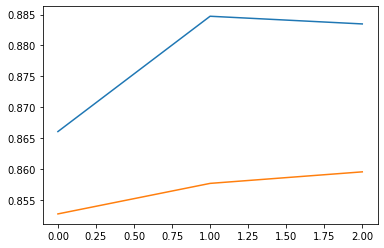

In [8]:
plt.plot(np.arange(0,acc.shape[1],1), acc[1], label='val acc')
plt.plot(np.arange(0,acc.shape[1],1), acc[0], label='train acc')

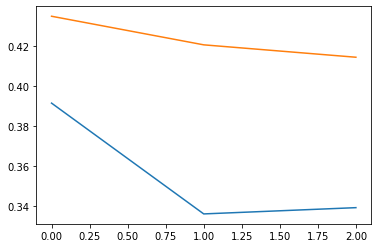

In [9]:
plt.plot(np.arange(0,loss.shape[1],1), loss[1], label='val acc')
plt.plot(np.arange(0,loss.shape[1],1), loss[0], label='train acc')

In [10]:
PATH='/media/sergio/traballos sergio/msi/models/cassava/VGG16-2.h5'
torch.save(model, PATH)

In [ ]:
PATH='/media/sergio/traballos sergio/msi/models/cassava/VGG16-2-best.h5'
torch.save(model_ft, PATH)

In [19]:
model, loss, acc = train_model(model, dataloader, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=2)

Epoch 0/1
----------
images: 1000
0 Loss: 0.4861 Acc: 0.8330
1 Loss: 0.3932 Acc: 0.8623

Epoch 1/1
----------
images: 1000
0 Loss: 0.4753 Acc: 0.8360
1 Loss: 0.4009 Acc: 0.8617

Training complete in 27m 41s
Best val Acc: 0.862305
train loss: [0.4860530502452251, 0.47531284963301507]

val loss: [0.3931747988661362, 0.4008864563196387]

train acc: [0.8329576070819816, 0.8359817452026173]

val acc: [0.8623052959501558, 0.8616822429906542]


# Semi-train 

In [4]:
#Data transformations for data augmentation
jitter_param = 0.05
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(512),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(
            brightness=jitter_param,
            contrast=jitter_param,
            saturation=jitter_param),
        transforms.RandomRotation(degrees=(-10,10), 
                                  resample=False, 
                                  expand=False, 
                                  center=None, 
                                  fill=None),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.656, 0.406], [0.229, 0.224, 0.225])
    ])

val_transform = transforms.Compose([
        transforms.Resize(544),
        transforms.CenterCrop(512),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.656, 0.406], [0.229, 0.224, 0.225])
    ])

#We define the dataset class
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, imgs, labels, transform=None):
        self.imgs = imgs
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, ix):
        img = Image.open(self.imgs[ix])
        label = torch.tensor(self.labels[ix], dtype = torch.long)
        if self.transform:
            img = self.transform(img)
        return img, label
    
    def check(self):
        if len(self.img) == len(self.labels):
            print('Okey!')
        else:
            print('imgs and labels different len')

#Take train data and create a dataset class with it
database_base_path = '/media/sergio/traballos sergio/msi/datasets/kaggle/cassava/'
df = pd.read_csv(database_base_path + 'train.csv')
#imgs = [database_base_path + 'train_images/' + img for img in os.listdir(database_base_path)]

#Shuffle data
df = df.sample(frac=1)

#Take imgs and labels
imgs = [database_base_path + 'train_images/' + img for img in df['image_id'].values]
labels = df['label'].values

train_val_split = 0.85
batch_size = 4

train_dataset = Dataset(imgs[0:1000], 
                        labels[0:1000], 
                        train_transform)
val_dataset = Dataset(imgs[1000:1500], 
                      labels[1000:1500], 
                      val_transform)

#create the dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=True, num_workers=4)
validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                                shuffle=False, num_workers=4)

dataloader = []
dataloader.append(train_loader)
dataloader.append(validation_loader)

dataset_sizes = []
dataset_sizes.append(len(train_dataset))
dataset_sizes.append(len(val_dataset))

In [5]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model.parameters(), lr=0.0004, momentum=0.75)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [6]:
model_ft, loss, acc = train_model(model, dataloader, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
0 Loss: 1.0568 Acc: 0.6270
1 Loss: 0.8532 Acc: 0.6900

Epoch 1/4
----------
0 Loss: 0.8328 Acc: 0.7030
1 Loss: 0.7425 Acc: 0.7140

Epoch 2/4
----------
0 Loss: 0.7650 Acc: 0.7210
1 Loss: 0.7552 Acc: 0.7460

Epoch 3/4
----------
0 Loss: 0.6953 Acc: 0.7460
1 Loss: 0.5977 Acc: 0.7860

Epoch 4/4
----------
0 Loss: 0.6340 Acc: 0.7760
1 Loss: 0.5638 Acc: 0.7960

Training complete in 10m 28s
Best val Acc: 0.796000
train loss: [1.0568047612160445, 0.8328112070299685, 0.7649963339082897, 0.6953401897419244, 0.6339830619012937]

val loss: [0.8531824520230293, 0.7424661910682917, 0.7552129698395729, 0.5976854954753071, 0.5638218698287383]

train acc: [0.627, 0.7030000000000001, 0.721, 0.746, 0.776]

val acc: [0.6900000000000001, 0.714, 0.746, 0.786, 0.796]


In [ ]:
last acc: [0.87507] resnet

In [ ]:
0.7400.. jitter_param = 0.05 ..standard norm ..lr=0.0004, momentum=0.75 ..13 layers
0.7760 ..same ..same.. same..10 layers
0.7960 ..jitter_param = 0.05 norm green =0.656